In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import math

import sys
import os
sys.path.append(os.getcwd() + "/pytorch_tabnet/")

from sklearn.cluster import DBSCAN

## 0. Configuration Parameters
Customizing constants for the run(s).

In [2]:
# config
#np.random.seed(2123)

# percentage of features that used to predict missing values (features will be randomly chosen)
pred_features = 100

# number of prediction runs performed with the randomly chosen features
runs = 2

# DBSCAN hyperparameters
eps=3
min_samples=5

## 1. Datasets

### 1.0. Create or load dataset
As of now, only a toy dataset is used (3 features with 3 clusters centered around different points).

In [3]:
from sklearn.datasets import make_blobs

features_arr, clusters_arr = make_blobs(n_samples=[50, 100, 50],
                                centers=[[1, 5, 1], [7, 12, 9], [10, 2, 5]],
                                n_features=3,
                                cluster_std=1.5, )

### 1.1. plot data

<IPython.core.display.Javascript object>


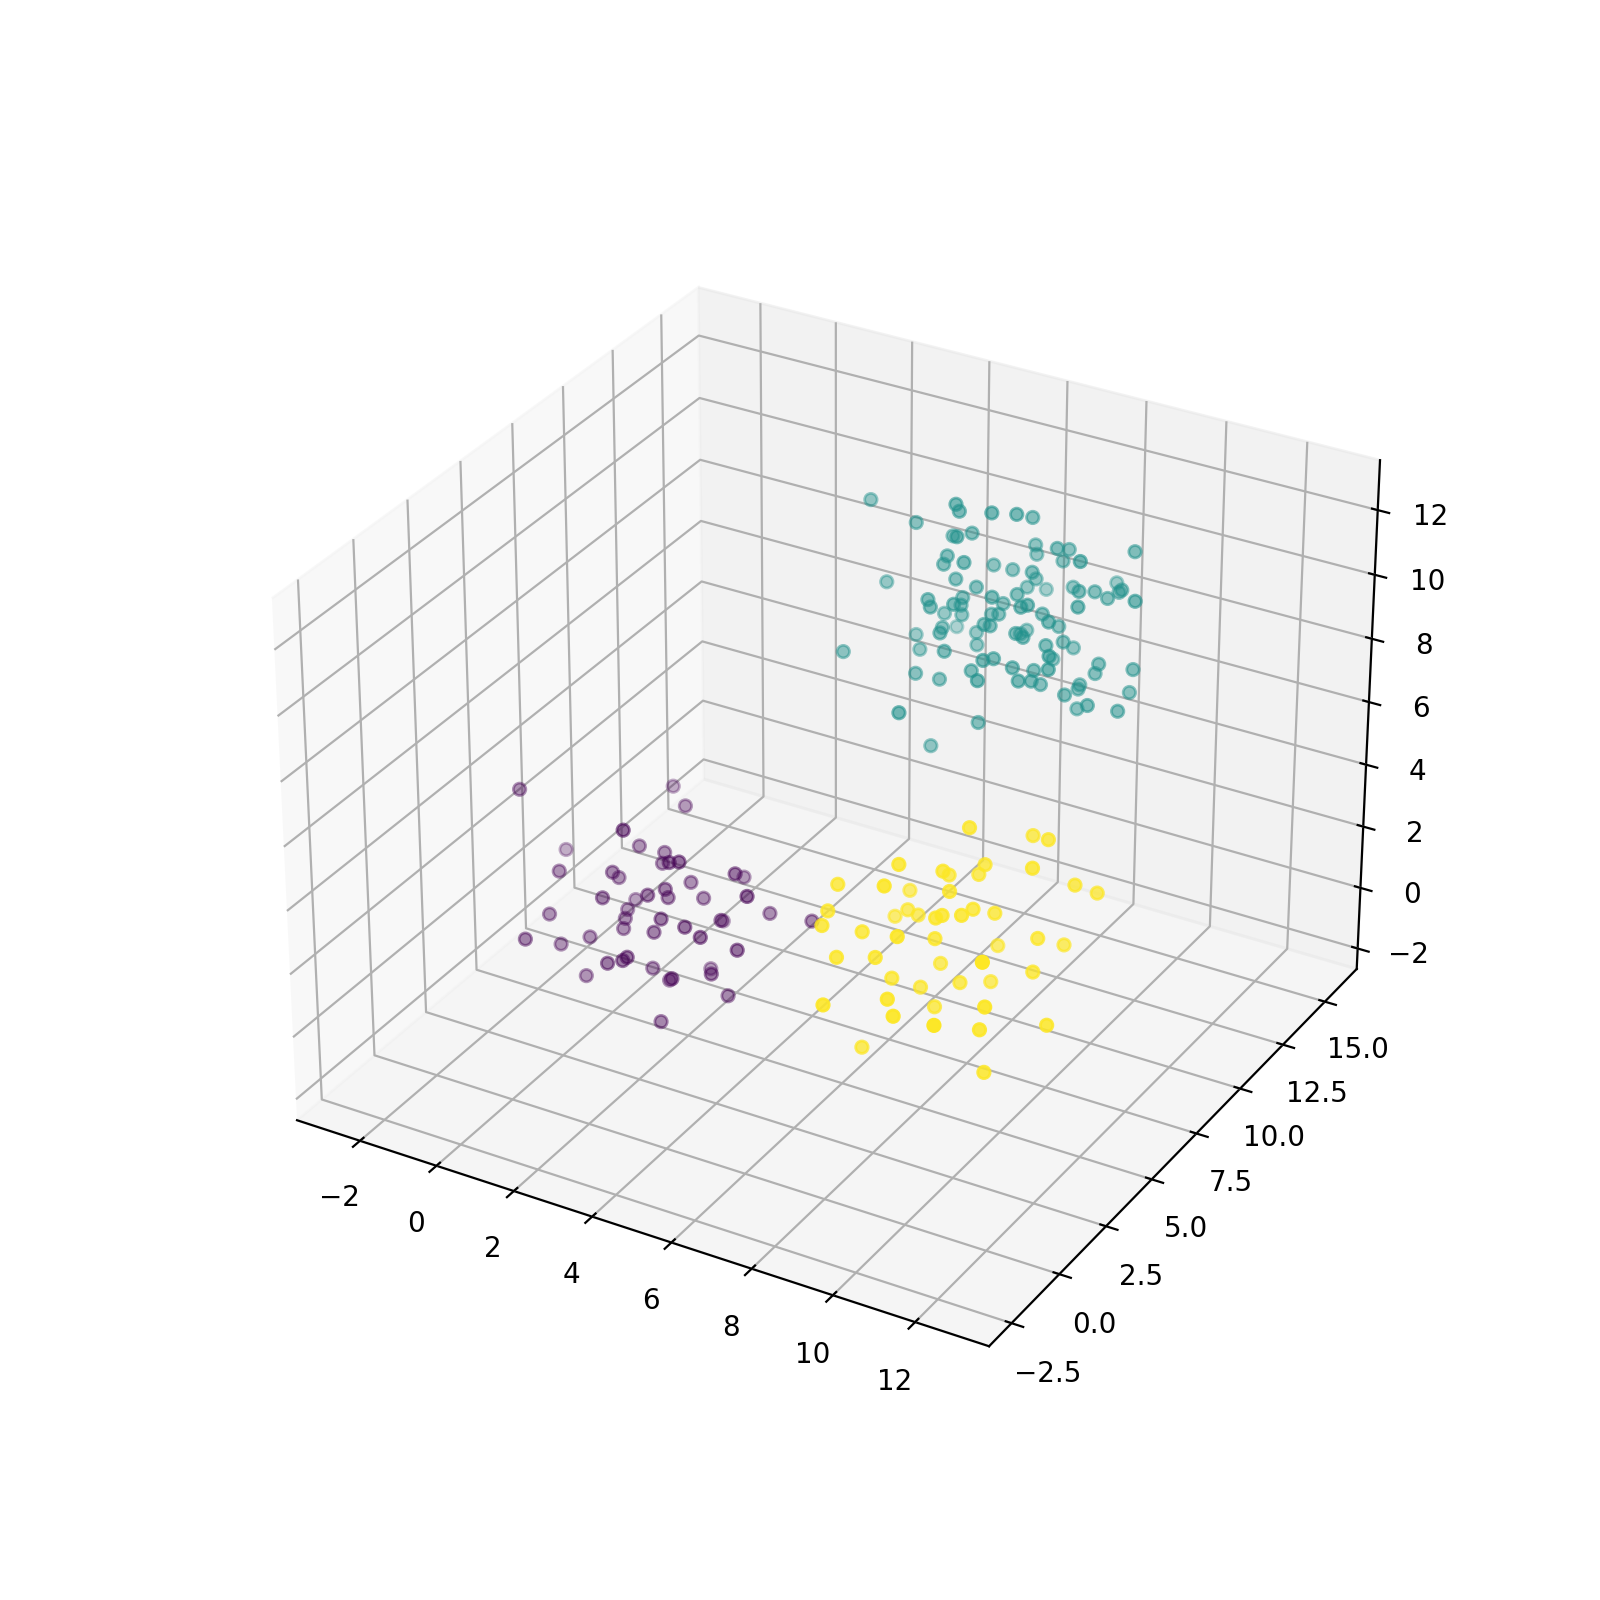

In [4]:
# plot dataset
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_arr[:, 0], features_arr[:, 1], features_arr[:, 2], c=clusters_arr)
plt.show()

### 1.2. Create missing data
Create a specified amount of missing values in the given feature columns (for complete datasets).

In [5]:
# name feature and cluster (ground truth) columns
features = pd.DataFrame(features_arr, columns=[f"F{x + 1}" for x in range(features_arr.shape[1])])
clusters = pd.DataFrame(clusters_arr, columns=["C"])

# create missing values in feature column(s)
mv_percent = [0, 15, 10]  # percentages of missing values created in the feature columns
mv_config = {feature:mv_ratio for feature,mv_ratio in zip(list(features.columns), mv_percent)}
features_mv = features.copy()

for f, mv in mv_config.items():
    features_mv[f] = features_mv[f].mask(np.random.random(features.shape[0]) < mv / 100)

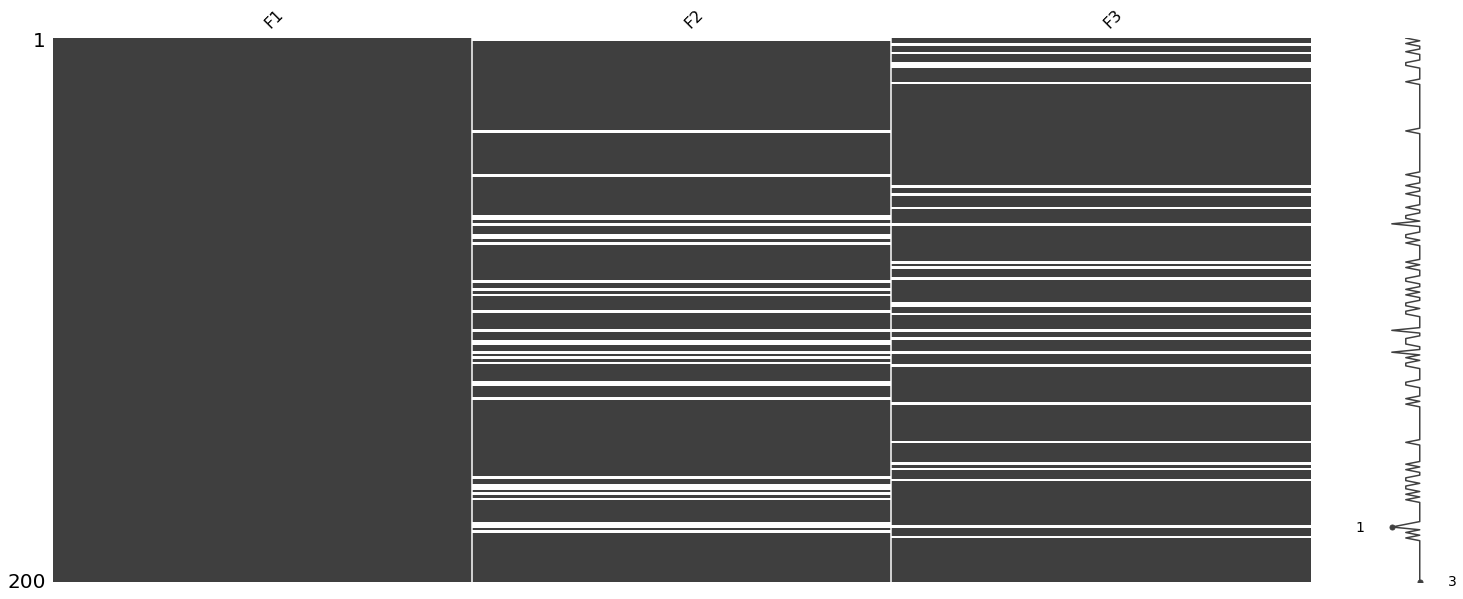

In [6]:
import missingno as msno
%matplotlib inline
# plot missing values
msno.matrix(features_mv)
plt.show()

### 1.3. Initial Clustering (without missing values)
Use the cluster algorithm on dataset without missing values.\
Get cluster means for loss function input.

In [7]:
dbscan_orig = DBSCAN(eps=eps, min_samples=min_samples).fit(features)
clusters_orig = dbscan_orig.labels_

<IPython.core.display.Javascript object>


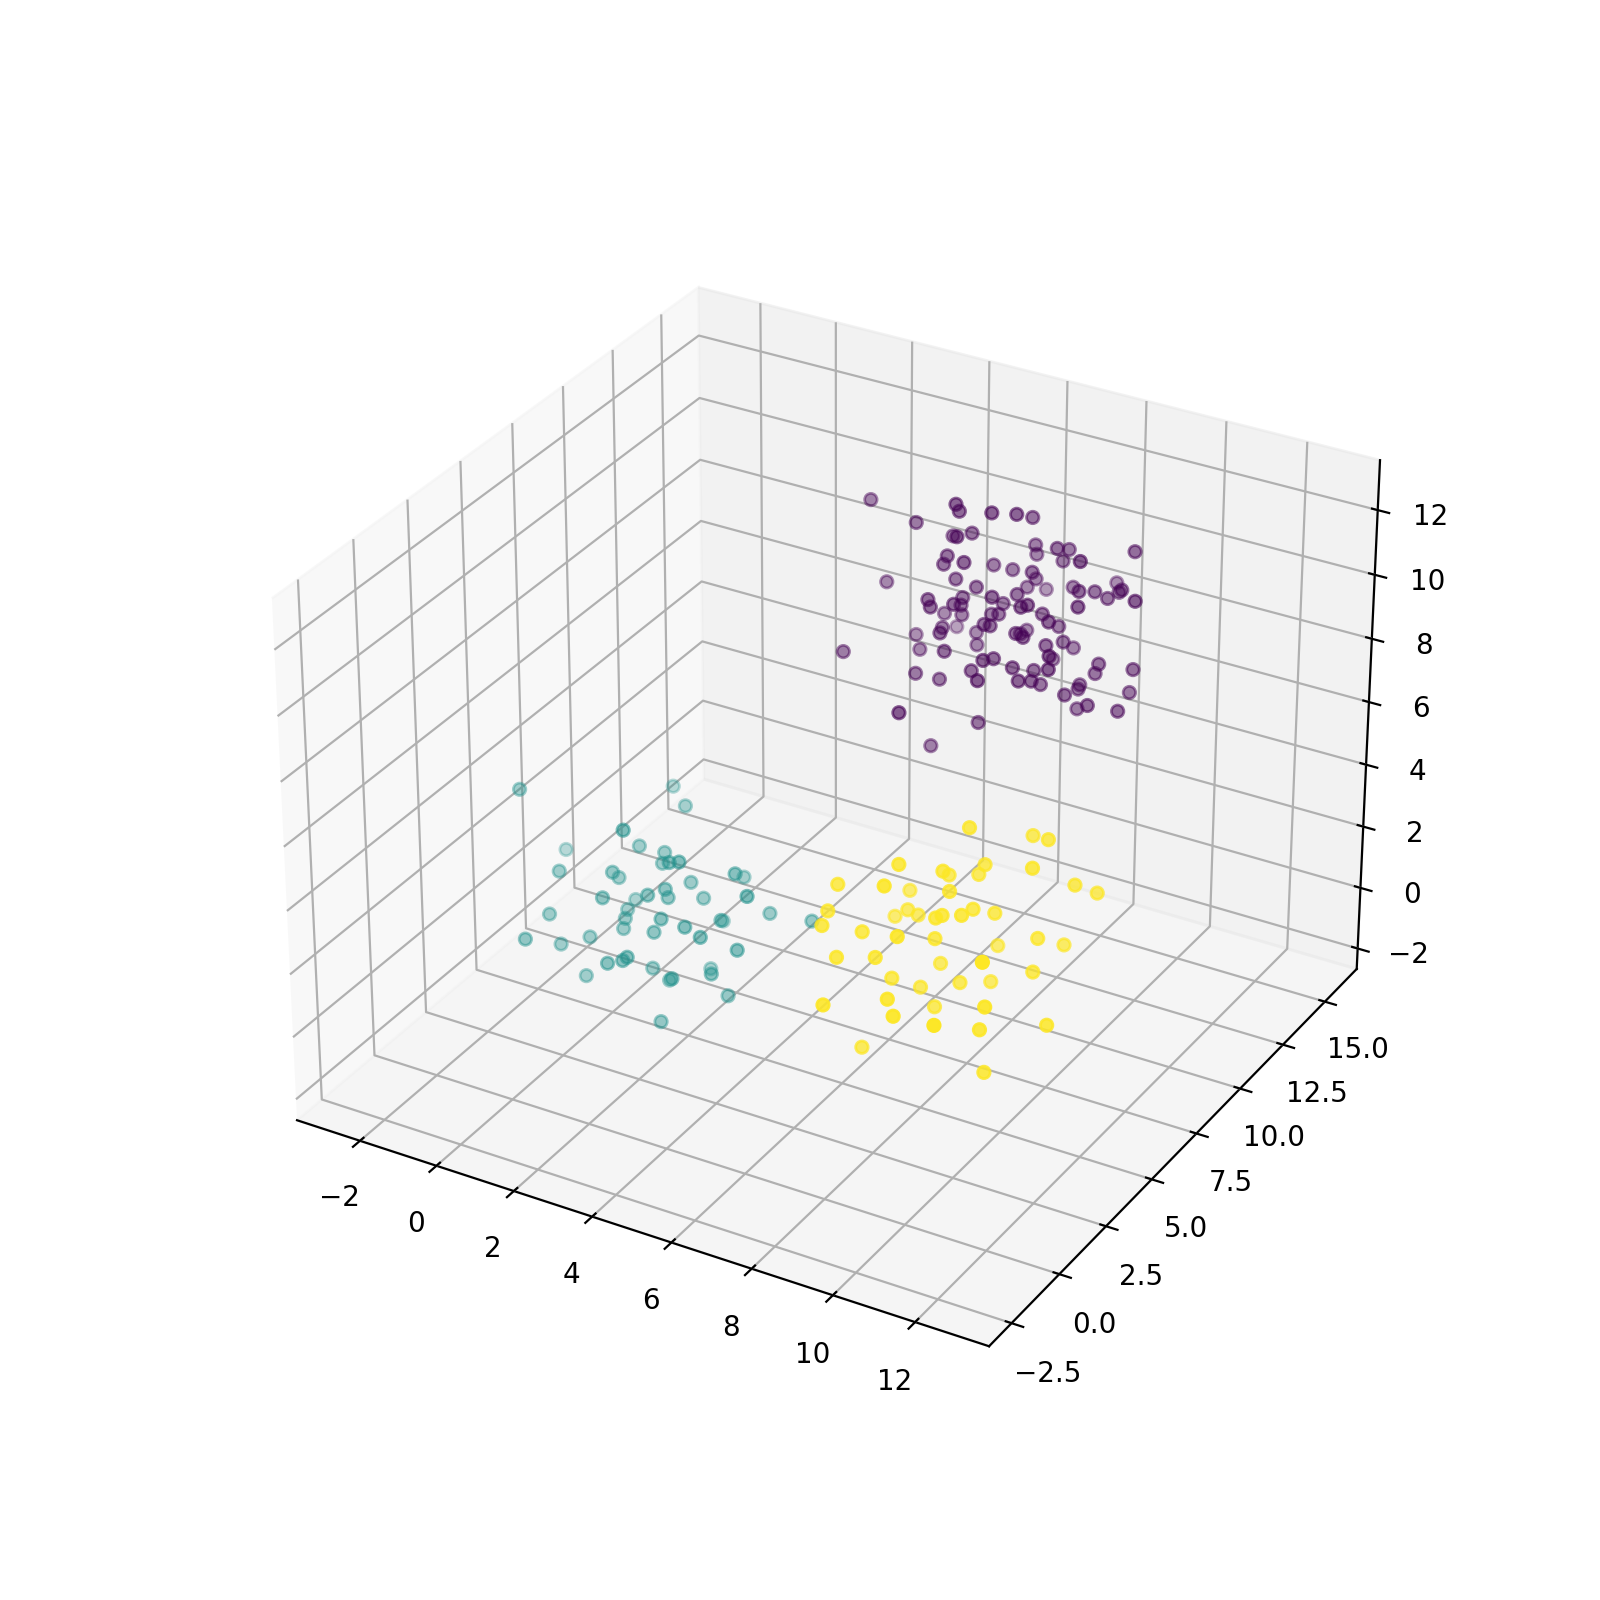

In [8]:
# plot clustering
%matplotlib notebook
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features.iloc[:, 0], features.iloc[:, 1], features.iloc[:, 2], c=clusters_orig)
plt.show()

In [10]:
# get cluster means
complete_data = features.copy()
complete_data["C"] = clusters_orig
cluster_means = complete_data.groupby("C").agg("mean")

## 2. Filling Strategies


**custom-loss**\
The loss function for the model fitting shall be customized, depending on the goal to improve cluster perforamnce. The custom loss is divided into 2 separate losses

1. **Reconstruction Loss**\
Classic loss function, such as RMSE.
2. **Cluster-Mean Loss**\
The distance to the nearest cluster mean shall be minimized.

As of now, there are 2 possible approaches to implement the cluster-mean loss
1. **Adapt the loss function** to calculate a distance to each cluster. The minimum distance (to the nearest cluster) will be used as a cluster-mean-loss. Minimizing this loss should result in the data point moving closer to the nearest cluster mean.\
Potential Problem: loss functions currently work with y_true (true values) and y_score (predicted values). Calculating the distance would require all features. Calculating only the 1 dimensional distance will result in missing values being put into wrong clusters - depending on the first estimate.\

2. **Adapting the ground truth** to reflect the cluster-mean-loss. Following e.g. MSE, that is learning from the true labels.

In [11]:
# define custom loss function: extend L2-loss by cluster-mean-loss

from pytorch_tabnet.metrics import Metric
from sklearn.metrics import mean_squared_error

class custom_loss(Metric):

    def __init__(self):
        self._name = "custom_loss"
        self._maximize = False

    def __call__(self, y_true, y_score, cluster_means, target_feature):
        rmse = np.sqrt(mean_squared_error(y_true, y_score))
        cml = self.cluster_mean_loss(cluster_means, y_score, target_feature)
        custom_loss = cml + rmse
        return custom_loss
    
    # calculate sum of distances to the closest cluster mean
    def cluster_mean_loss(self, cluster_means, y_score, target_feature):
        
        dist = pd.DataFrame(y_score, columns=[target_feature])
        
        # calculate distances to each cluster and select the closest one
        for feature, cluster in cluster_means.iterrows():
            dist[f"D{feature}"] = abs(dist[target_feature] - cluster[target_feature])
            
        dist = dist.drop(target_feature,axis=1)
        min_dist = dist.assign(min_dist=lambda d: d.min(1))["min_dist"]
        return sum(abs(min_dist))
        

Fill missing values (here with TabNet).

**Approach 1:**\
For each feature that contains missing values, use all rows with complete other features as train set and predict missing values of the feature.\
&rarr; Problem: lots of models, especially for high-dimensional datasets. 
Also problem, if more than one feature is missing values. &rarr; see Approach 2

**Approach 2:**\
Mask missing values as -1 (or some other value) and fit a model predicting each feature just like in approach 1.\
&rarr; one model for each feature containing missing values.\
Possible adaption: use predicted values to predict subsequent values (instead of using -1)

In [12]:
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.model_selection import train_test_split

features_filled = []

for run in range(runs):
    for feature in features_mv.columns[features_mv.isnull().any()]:
        print(f"Run {run+1}, predicting {feature}")
        features_filled.append(features_mv.copy())

        # select % of features for prediction based on pred_features (e.g. 10% of randomly selected features)
        number_of_features = math.ceil((pred_features / 100) * (len(features_mv.columns)) - 1)
        features_mv_masked = features_mv.copy().drop(feature, axis=1).sample(n=number_of_features, axis='columns')
        selected_features = features_mv_masked.columns
        
        print(f"Predictions based on features {list(selected_features)}")
        
        # mask other columns' missing values as -1
        features_mv_masked[feature] = features_mv[feature]
        features_mv_masked[selected_features] = features_mv_masked[(selected_features)].fillna(-1)
        
        # separate complete rows as train data
        # separate column with missing values as target
        test_data = features_mv_masked[features_mv_masked[feature].isna()].drop(feature, axis=1).to_numpy()
        train_data = features_mv_masked[features_mv_masked[feature].notna()]
        train_features = train_data.drop(columns=feature).to_numpy()
        train_target = train_data[feature].to_numpy().reshape(-1,1)

        x_train, x_val, y_train, y_val = train_test_split(train_features, train_target, test_size=0.75)

        # create & train model
        model = TabNetRegressor(optimizer_fn=torch.optim.Adam,
                            optimizer_params=dict(lr=2e-2),
                            scheduler_params={"step_size": 50, "gamma": 0.9},
                            scheduler_fn=torch.optim.lr_scheduler.StepLR,
                            mask_type='entmax')

        model.fit(
            x_train, y_train,
            eval_set=[(x_val, y_val)],
            eval_metric=['custom_loss'],
            max_epochs=200, patience=20,
            cluster_means=cluster_means,
            target_feature=feature,
        )

        # fill missing values with model predictions
        features_filled[run].loc[features_filled[run][feature].isna(),feature] = [x[0] for x in model.predict(test_data)]

Run 1, predicting F2
Predictions based on features ['F1', 'F3']
Device used : cpu
epoch 0  | loss: 43.4529 | val_0_custom_loss: 3259.8075|  0:00:00s
epoch 1  | loss: 30.15337| val_0_custom_loss: 3928.19948|  0:00:00s
epoch 2  | loss: 20.08699| val_0_custom_loss: 1932.91333|  0:00:00s
epoch 3  | loss: 14.3194 | val_0_custom_loss: 1880.99149|  0:00:00s
epoch 4  | loss: 9.8785  | val_0_custom_loss: 2217.60376|  0:00:00s
epoch 5  | loss: 6.54539 | val_0_custom_loss: 2634.33011|  0:00:00s
epoch 6  | loss: 5.16781 | val_0_custom_loss: 3090.57556|  0:00:00s
epoch 7  | loss: 4.64205 | val_0_custom_loss: 3313.39504|  0:00:00s
epoch 8  | loss: 4.06398 | val_0_custom_loss: 3040.87189|  0:00:00s
epoch 9  | loss: 3.14209 | val_0_custom_loss: 2531.94534|  0:00:00s
epoch 10 | loss: 2.69001 | val_0_custom_loss: 2300.14677|  0:00:00s
epoch 11 | loss: 2.57117 | val_0_custom_loss: 2255.92553|  0:00:00s
epoch 12 | loss: 2.2676  | val_0_custom_loss: 2262.03877|  0:00:00s
epoch 13 | loss: 2.08325 | val_0_cu

epoch 49 | loss: 0.97551 | val_0_custom_loss: 606.071 |  0:00:02s
epoch 50 | loss: 0.99359 | val_0_custom_loss: 594.71266|  0:00:02s
epoch 51 | loss: 0.96914 | val_0_custom_loss: 533.35869|  0:00:02s
epoch 52 | loss: 0.9851  | val_0_custom_loss: 473.91442|  0:00:02s
epoch 53 | loss: 1.0015  | val_0_custom_loss: 456.73283|  0:00:02s
epoch 54 | loss: 0.96087 | val_0_custom_loss: 489.33529|  0:00:02s
epoch 55 | loss: 0.99782 | val_0_custom_loss: 513.7585|  0:00:02s
epoch 56 | loss: 0.99056 | val_0_custom_loss: 513.00507|  0:00:02s
epoch 57 | loss: 0.97156 | val_0_custom_loss: 488.12579|  0:00:02s
epoch 58 | loss: 0.9513  | val_0_custom_loss: 461.4676|  0:00:02s
epoch 59 | loss: 0.92959 | val_0_custom_loss: 452.85376|  0:00:02s
epoch 60 | loss: 0.91836 | val_0_custom_loss: 462.8756|  0:00:02s
epoch 61 | loss: 0.95603 | val_0_custom_loss: 474.46483|  0:00:02s
epoch 62 | loss: 0.91826 | val_0_custom_loss: 472.78054|  0:00:02s
epoch 63 | loss: 0.9027  | val_0_custom_loss: 435.98469|  0:00:02s

epoch 85 | loss: 1.23173 | val_0_custom_loss: 546.23634|  0:00:02s
epoch 86 | loss: 1.24612 | val_0_custom_loss: 490.96182|  0:00:02s
epoch 87 | loss: 1.24612 | val_0_custom_loss: 441.40079|  0:00:02s
epoch 88 | loss: 1.23434 | val_0_custom_loss: 430.45422|  0:00:02s
epoch 89 | loss: 1.20322 | val_0_custom_loss: 440.34744|  0:00:02s
epoch 90 | loss: 1.16704 | val_0_custom_loss: 444.30206|  0:00:02s
epoch 91 | loss: 1.06221 | val_0_custom_loss: 448.86208|  0:00:02s
epoch 92 | loss: 1.20883 | val_0_custom_loss: 455.63982|  0:00:02s
epoch 93 | loss: 1.22509 | val_0_custom_loss: 461.9792|  0:00:02s
epoch 94 | loss: 1.09538 | val_0_custom_loss: 426.49157|  0:00:02s
epoch 95 | loss: 1.05595 | val_0_custom_loss: 387.06579|  0:00:02s

Early stopping occurred at epoch 95 with best_epoch = 75 and best_val_0_custom_loss = 367.33155
Best weights from best epoch are automatically used!
Run 2, predicting F3
Predictions based on features ['F2', 'F1']
Device used : cpu
epoch 0  | loss: 25.18023| val_0

## 3. Complete Dataset
Complete dataset and deviation of original dataset

In [13]:
# complete datasets
features_final = features_filled[0]

<IPython.core.display.Javascript object>


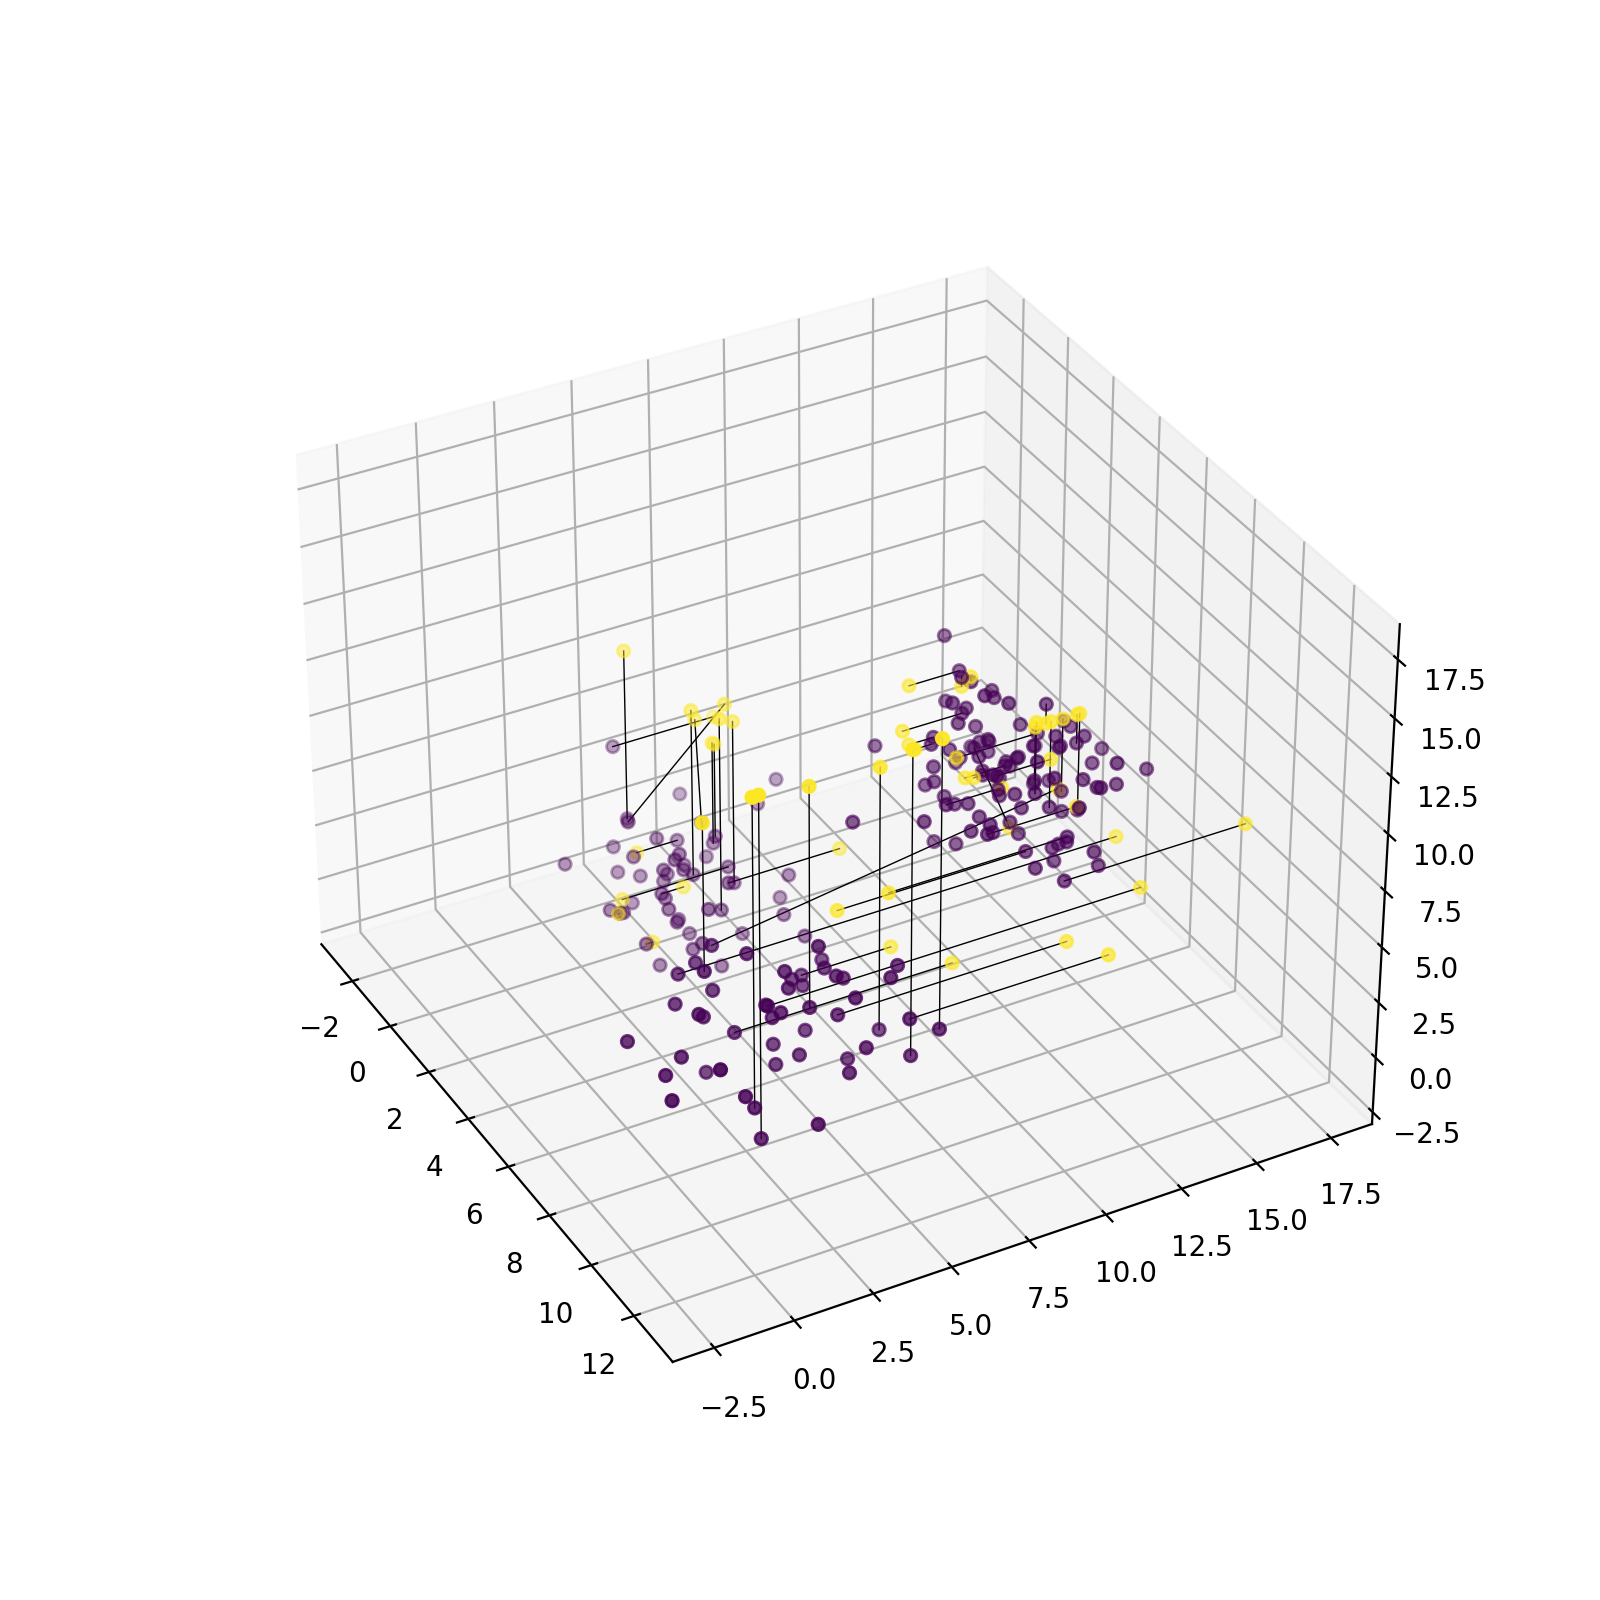

<function matplotlib.pyplot.show(block=None)>

In [14]:
# show changes

# scatter plot with combined data
orig_data = features.copy()
orig_data["change"] = 0
changed_data = features_final[features_mv.isna().any(axis=1)]
comp_data = pd.concat([orig_data, changed_data]).reset_index(drop=True).fillna(1)

# line plot connecting filled data to true data points
filled_data = features_final[features_mv.isna().any(axis=1)]
true_data = features[features_mv.isna().any(axis=1)]

# plot
fig = plt.figure(figsize=(8, 8))
ax  = fig.add_subplot(projection = '3d')
ax.scatter(comp_data["F1"], comp_data["F2"], comp_data["F3"], c=[comp_data["change"]])

for i in range(len(filled_data)):
    ax.plot([filled_data["F1"].iloc[i], true_data["F1"].iloc[i]],[filled_data["F2"].iloc[i], true_data["F2"].iloc[i]],[filled_data["F3"].iloc[i], true_data["F3"].iloc[i]], color="black", linewidth=.5)

plt.show

## 4. Clustering

In [15]:
# apply clustering
dbscan_filled = DBSCAN(eps=3, min_samples=min_samples).fit(features_final)
clusters_filled = dbscan_filled.labels_

<IPython.core.display.Javascript object>


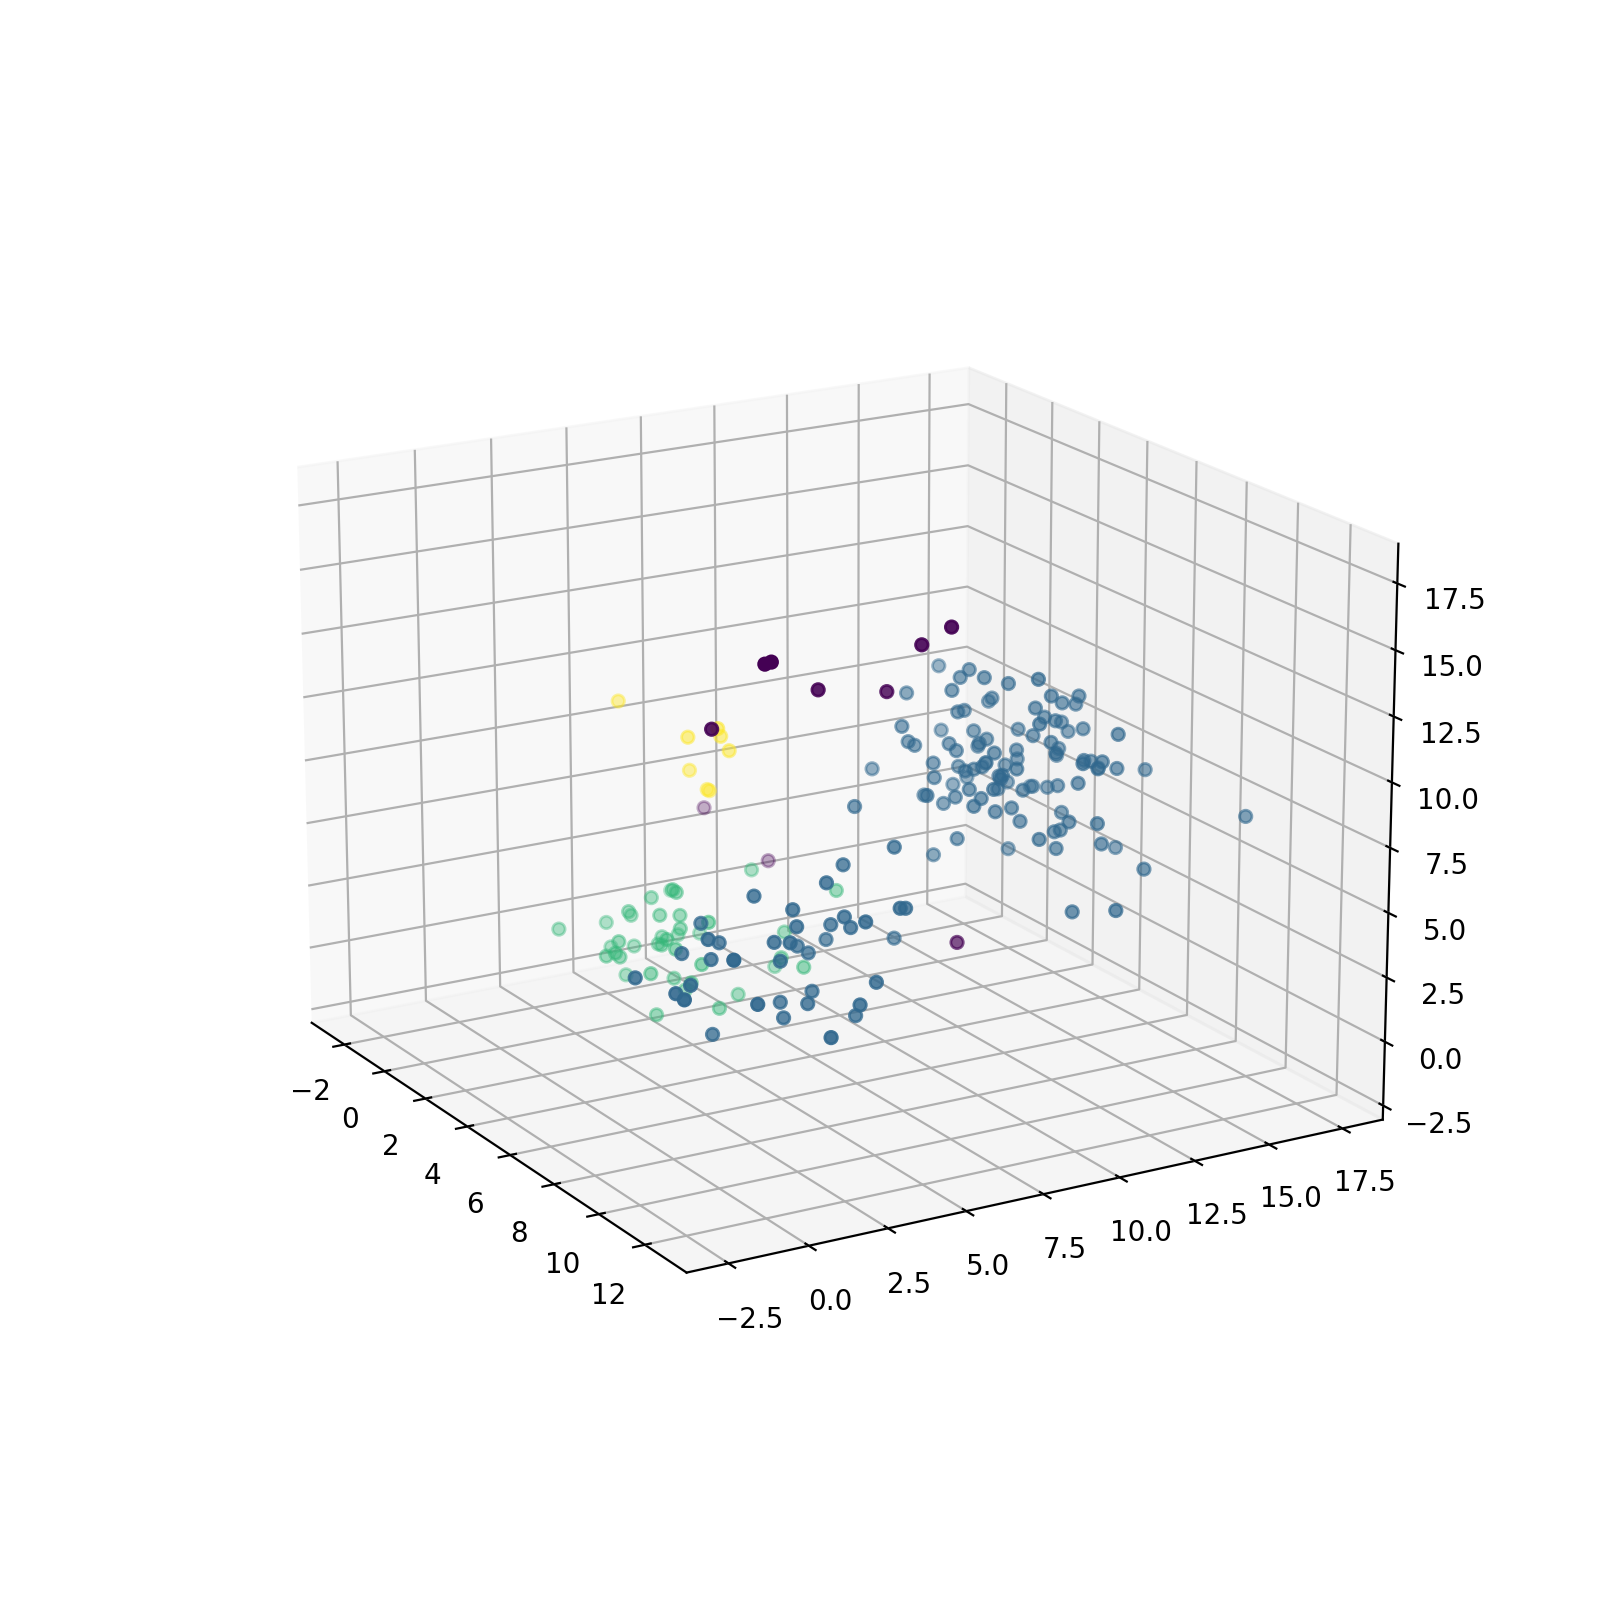

In [16]:
# plot new clustering
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
ax.scatter(features_final.iloc[:, 0], features_final.iloc[:, 1], features_final.iloc[:, 2], c=clusters_filled)
plt.show()

## 5. Cluster Performance
### 5.1 Feature Distributions
#### 5.1.1 Distr. Plots

<IPython.core.display.Javascript object>


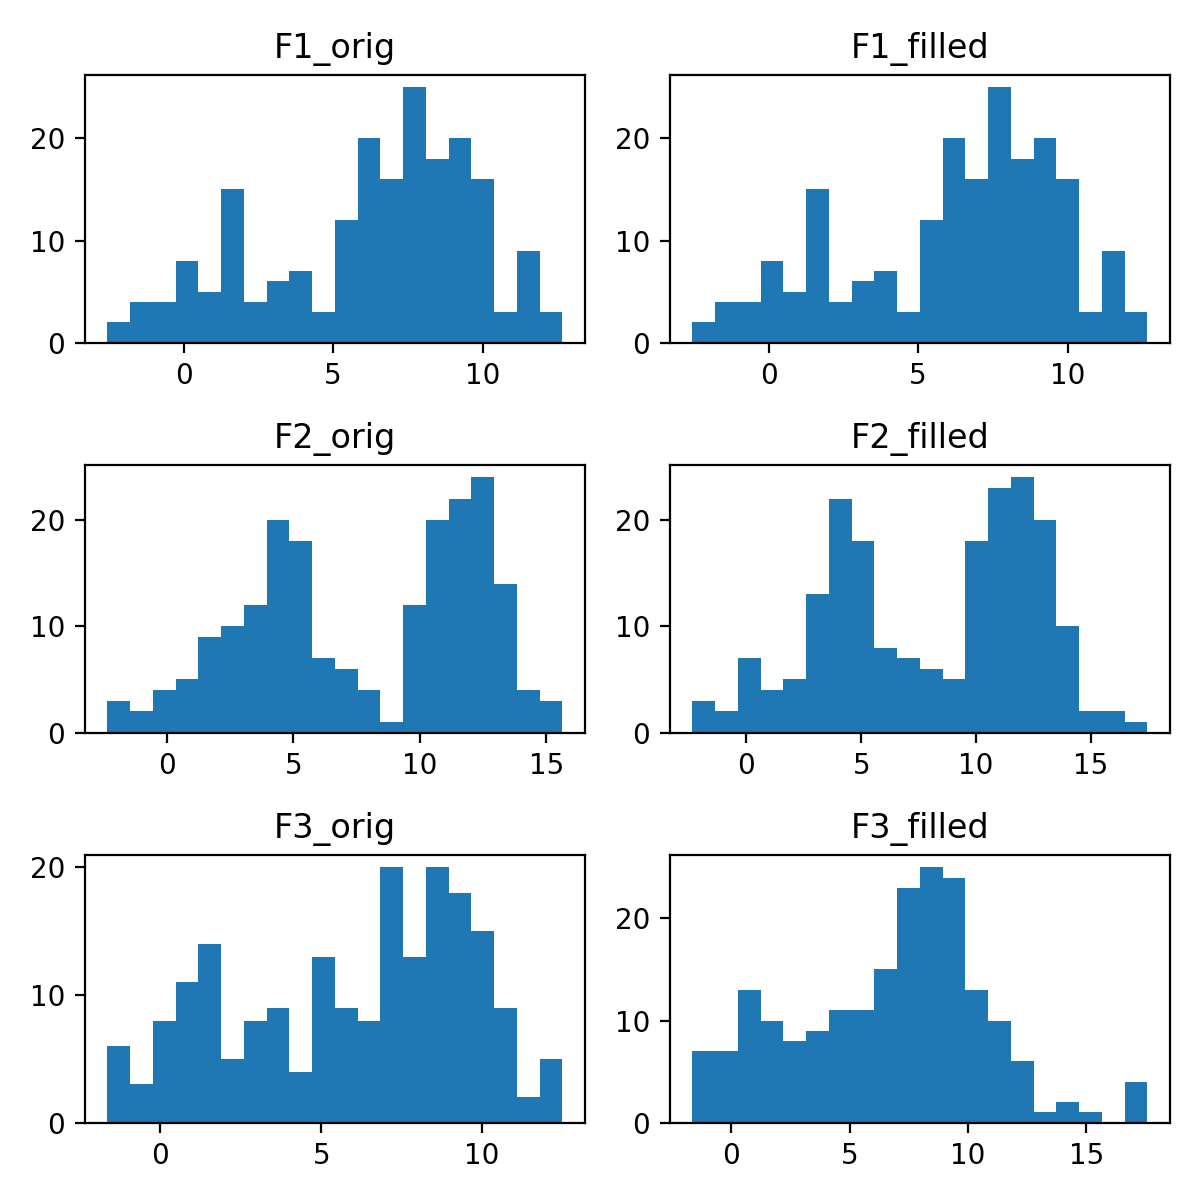

In [19]:
# plot distributions
bins = 20
n_feat = len(features_final.columns)

fig, (ax) = plt.subplots(n_feat, 2, figsize=(n_feat*2,6))
for n, feature in enumerate(features_final.columns):
    ax[n, 0].hist(features[feature], bins=bins)
    ax[n, 0].set_title(f"{feature}_orig")
    ax[n, 1].hist(features_final[feature], bins=bins)
    ax[n, 1].set_title(f"{feature}_filled")

fig.tight_layout()
plt.show()

#### 5.1.2 KL Divergence
Based on implementation from https://stackoverflow.com/questions/57687458/how-to-calculate-probabilities-using-numpy-histogram-and-then-use-it-for-calcula

In [20]:
# calculating the kl divergence (relative entropy) with scipy
from scipy.special import rel_entr

# calculate probabilities
def probability_dist(x, y, bins):
    # histogram
    hist_xy = np.histogram2d(x, y, bins=bins)[0]

    # compute marginals
    hist_xy = hist_xy + sys.float_info.min # prevent division with 0
    hist_xy = hist_xy / np.sum(hist_xy)
    hist_x = np.sum(hist_xy, axis=1)
    hist_y = np.sum(hist_xy, axis=0)
    return(hist_x, hist_y)

# calculate kl divergence
for n, feature in enumerate(features_final):
    dist1, dist2 = probability_dist(features[feature], features_final[feature], bins)
    print(f"KL divergence {feature}_orig to {feature}_filled: {sum(rel_entr(dist1, dist2))}")
    print(f"KL divergence {feature}_filled to {feature}_orig: {sum(rel_entr(dist2, dist1))}")
    print("")
    

KL divergence F1_orig to F1_filled: 0.0
KL divergence F1_filled to F1_orig: 0.0

KL divergence F2_orig to F2_filled: 0.2607841497048076
KL divergence F2_filled to F2_orig: 0.3194580897815629

KL divergence F3_orig to F3_filled: 7.5749309998032635
KL divergence F3_filled to F3_orig: 0.391456867305306



### 5.2 Cluster Performance
#### 5.3 Outliers

In [21]:
print(f"Number of outliers orig_data: {sum(clusters_orig == -1)}")
print(f"Number of outliers filled_data:{sum(clusters_filled == -1)}")

Number of outliers orig_data: 0
Number of outliers filled_data:10


#### 5.4 Silhouette Score

In [22]:
from sklearn.metrics import silhouette_score

print(f"Silhouette Score orig_data: {silhouette_score(features, np.ravel(clusters))}")
print(f"Silhouette Score filled_data: {silhouette_score(features_final, clusters_filled)}")

Silhouette Score orig_data: 0.6625071302270843
Silhouette Score filled_data: 0.33447845495793743
